# Preparando ambiente

In [ ]:
#=========================================================================#
#                      Inicilizando o GEE
#=========================================================================#
# instalando eemont
!pip install -q eemont

# importa bibliotecas
import ee, geemap, eemont

# inicializando o GEE
ee.Authenticate()
ee.Initialize(project='ee-enrique')

#=========================================================================#
#              Instalando bibliotecas adicionais
#=========================================================================#
# instalações
!pip install -q ultraplot cartopy

# importa bibliotecas
import pandas as pd
import time
import numpy as np
import ultraplot as uplt
import warnings
warnings.filterwarnings("ignore")

# Mapa interativo

In [ ]:
# filtrar região de interesse
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
estado_sp = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
municipio_sp = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo'))

# função que transforma de Kelvin para Celsius
def kelvin_to_celsius(image):
    return image.subtract(273.15)\
                .copyProperties(image, ['system:time_start'])\
                .set('date', image.date().format('YYYY-MM-dd'))

# carregando os dados
t2m = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .select('temperature_2m') \
        .filterDate('2025-06-01', '2025-07-01') \
        .map(kelvin_to_celsius) \
        .mean()

# paleta de cores
vis_t2m = {'min': 10,
           'max': 40,
           'palette': ['000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff', '00ff80',
                       '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00', 'ffb000', 'ffa400',
                       'ff4f00', 'ff2500', 'ff0a00', 'ff00ff']}

# cria a moldura do mapa
Map = geemap.Map()

# centraliza o mapa
Map.centerObject(estado_sp, 7)

# plota mapa
Map.addLayer(t2m.clip(estado_sp),
             vis_t2m,
             'Temperatura máxima em 2m')

# contorno da região
style1 = {'color': 'black', 'fillColor': '00000000'}
style2 = {'color': 'red', 'fillColor': '00000000'}
Map.addLayer(estado_sp.style(**style1), {}, 'estado_SP')
Map.addLayer(municipio_sp.style(**style2), {}, 'cidade_SP')

# barra de cores
colors = vis_t2m["palette"]
vmin = vis_t2m["min"]
vmax = vis_t2m["max"]
Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name='Temperatura')

# exibe na tela
Map

# Série temporal

## Gera série temporal

In [16]:
%%time
#========================================================================================================================#
#                                        Filtrar região de interesse
#========================================================================================================================#
municipio_sp = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo'))

#========================================================================================================================#
#                                Função que transforma de Kelvin para Celsius
#========================================================================================================================#
def kelvin_to_celsius(image):
    return image.subtract(273.15)\
                .copyProperties(image, ['system:time_start'])\
                .set('date', image.date().format('YYYY-MM-dd'))

#========================================================================================================================#
#                                            Loop nos anos
#========================================================================================================================#
# data inicial
data_inicial = '2020-01-01'

# data final
data_final = '2025-01-01'

#-------------------------------#
#      carrega os dados
#-------------------------------#
t2m = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .select('temperature_2m') \
        .filterDate(data_inicial, data_final) \
        .map(kelvin_to_celsius)

#-------------------------------#
#        série temporal
#-------------------------------#
t2m_ts = t2m.getTimeSeriesByRegion(reducer = [ee.Reducer.mean()],
                                   geometry = municipio_sp,
                                   bands = 'temperature_2m',
                                   scale = 11_000)

# inserindo os dados numa tabela
t2m_ts = geemap.ee_to_df(t2m_ts)

# transformando -9999.0 em NaN
t2m_ts[t2m_ts == -9999] = np.nan

# eliminando os dados NaN
t2m_ts = t2m_ts.dropna()

# transformando para DateTime
t2m_ts['date'] = pd.to_datetime(t2m_ts['date'], infer_datetime_format = True)

# transformando a coluna de datas('date') no índice do DataFrame
t2m_ts.index = t2m_ts['date']

# remove colunas
t2m_ts.drop(['reducer','date'], inplace=True, axis=1)

# mostra os dados
t2m_ts

CPU times: user 39.3 ms, sys: 77 µs, total: 39.4 ms
Wall time: 5.97 s


,temperature_2m
date,
2020-01-01,25.132745
2020-01-02,22.887603
2020-01-03,20.768837
2020-01-04,20.440553
2020-01-05,20.801985
...,...
2024-12-27,21.269614
2024-12-28,22.326919
2024-12-29,21.213950


## Gráfico

In [17]:
t2m_ts

,temperature_2m
date,
2020-01-01,25.132745
2020-01-02,22.887603
2020-01-03,20.768837
2020-01-04,20.440553
2020-01-05,20.801985
...,...
2024-12-27,21.269614
2024-12-28,22.326919
2024-12-29,21.213950


CPU times: user 619 ms, sys: 17.9 ms, total: 637 ms
Wall time: 640 ms


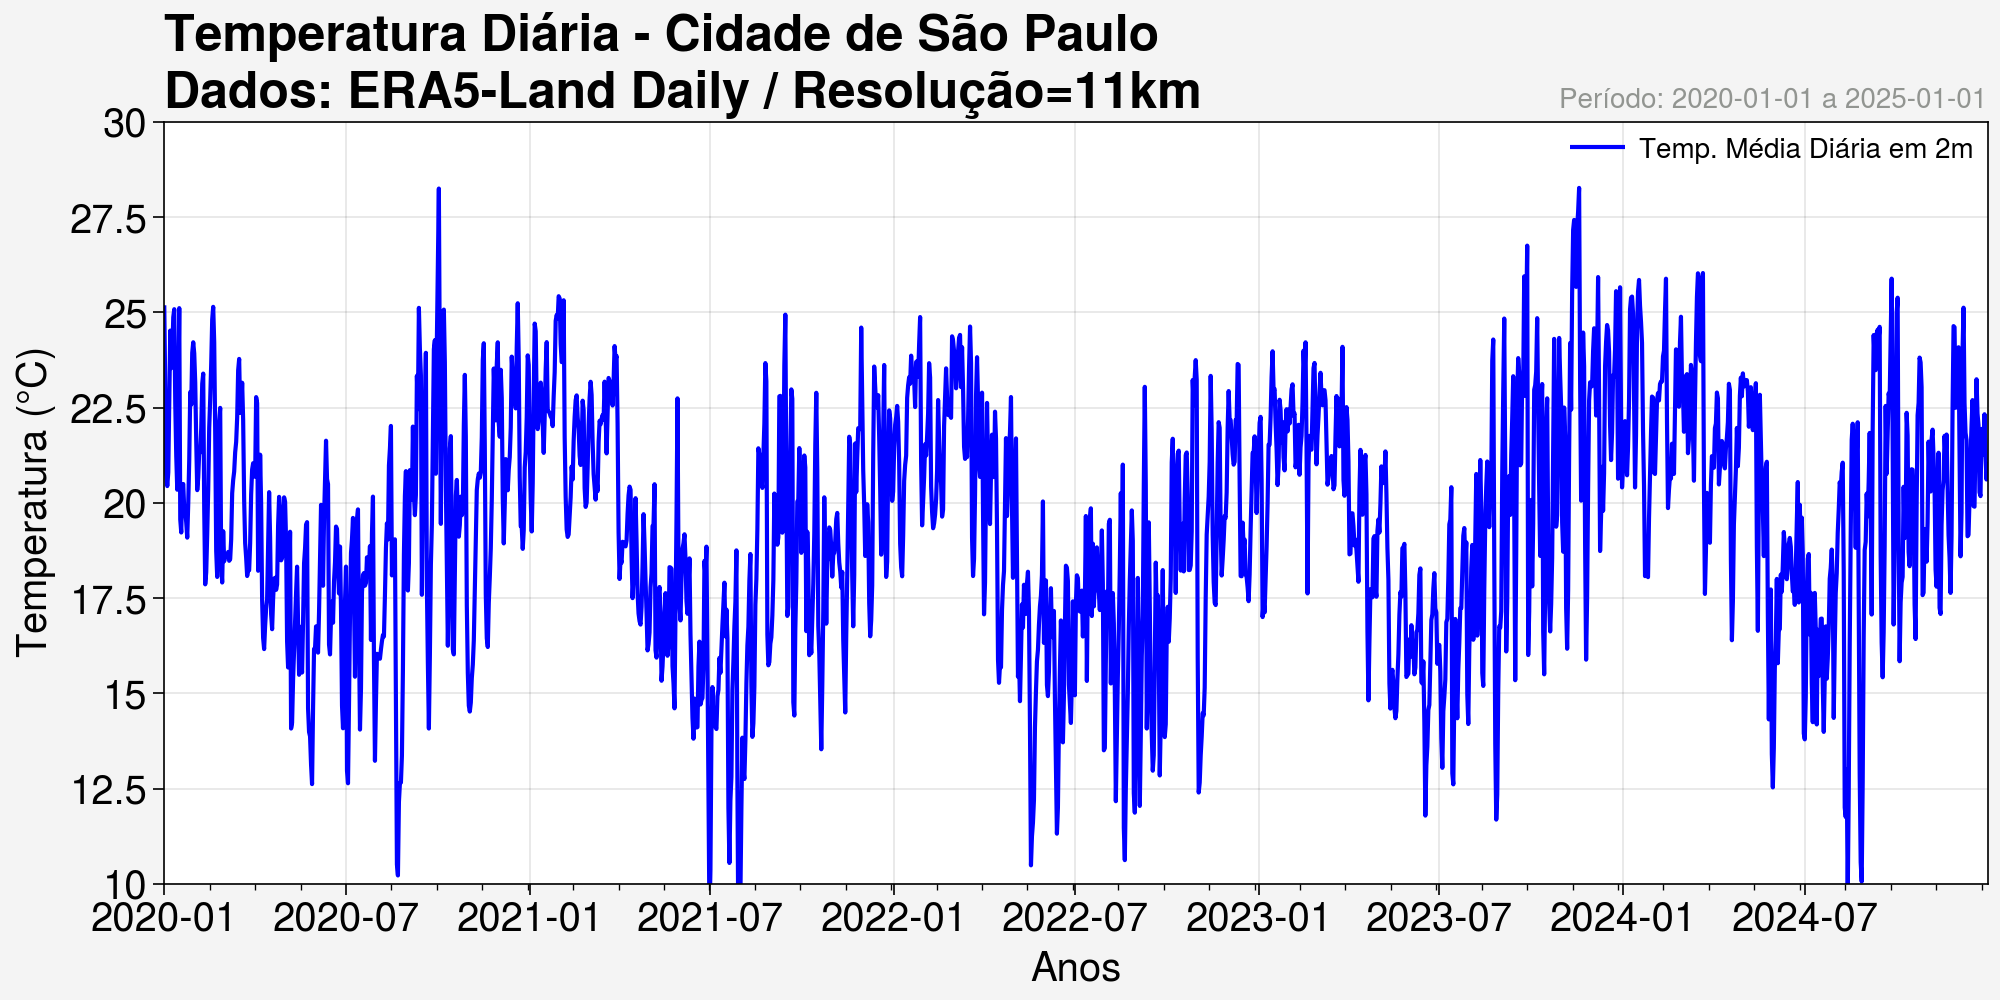

In [18]:
%%time
#========================================================================================================================#
#                                                PLOTA FIGURA
#========================================================================================================================#
# moldura da figura
fig, ax = uplt.subplots(figsize=(10,5), tight=True)

# plota gráfico de barras
ax.plot(t2m_ts['temperature_2m'].index, t2m_ts['temperature_2m'], color='blue', label='Temp. Média Diária em 2m')

# formato dos eixos
ax.format(title=f'Temperatura Diária - Cidade de São Paulo \nDados: ERA5-Land Daily / Resolução=11km',
          titleloc='l',
          titleweight='bold',
          titlecolor='black',
          xlabel='Anos',
          ylabel='Temperatura ($\degree$C)',
          ytickminor=False,
          small='20px',
          large='25px',
          xrotation=0,
          ylim=(10,30))

# escrever na linha do título a direita
ax.text(1, 1.01,
        f'Período: {data_inicial} a {data_final}',
        ha='right',
        va='bottom',
        transform=ax.transAxes,
        fontsize=10,
        color='gray')

# legenda
ax.legend(loc='best', ncols=1, frameon=False, prop={'size':10})

# salva figura
fig.save(f'Fig_1_ERA5_t2m_serie_temporal_diaria_{data_inicial}_a_{data_final}_muni_SP.jpg', dpi=300)